In [52]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.integrate import solve_ivp
from scipy.sparse import csr_matrix
from scipy.integrate import LSODA
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from ODE_schemes import A_matrix_regular
from bachelor_funcs import Σ_initial

In [53]:
N = 2001
r_in = 0.2 # AU
r_out = 3e2 # AU 
r = np.linspace(r_in, r_out, N)
Δr = r[1] - r[0]
print(Δr)

A = A_matrix_regular(N + 2, 3, 1) / Δr
A[0] = 0
A[0, 0] = 1
A[-1] = 0
A[-1, -1] = 1
sA = csr_matrix(A)
sA

0.14989999999999998


<2003x2003 sparse matrix of type '<class 'numpy.float64'>'
	with 4004 stored elements in Compressed Sparse Row format>

In [54]:
μ = 2.34    #(Hayashi 1981)
r_unit = r * u.au

def Omega_kep(r):
    return np.sqrt((G * M_sun) / r**3)

def temp(r, T_1au= 280 * u.K, p = -1/2):
    return T_1au * (r / (1 * u. au))**p

def soundspeed(r):
    return np.sqrt((k_B * temp(r)) / (μ * m_p))

In [55]:
r_ghost = np.concatenate((np.array([r[0] - Δr]), r, np.array([r[-1] + Δr])))
r_ghost

array([5.010000e-02, 2.000000e-01, 3.499000e-01, ..., 2.998501e+02,
       3.000000e+02, 3.001499e+02])

In [56]:
def one_alpha(t, Σ):
    Σ = Σ *  u.g * u.cm**-2
    r_ghost_au = r_ghost * u.au
    r_au = r * u.au
    #Σ = Σ_initial(r_au)

    inner = r_au**2 * Σ * α_rφ * soundspeed(r_au)**2
    inner_unit = inner.unit

    ghost_1 = np.array([inner[1].value])
    ghost_2 = np.array([inner[-2].value])

    inner_ghost = np.concatenate((ghost_1, np.array(inner), ghost_2)) * inner_unit
    inner_ghost

    outer_ghost = 2 / (r_ghost_au * Omega_kep(r_ghost_au)) * (A @ inner_ghost)

    sec_dev = 1/r_ghost_au * (A @ outer_ghost)

    df_dt = (sec_dev[1: -1] * u.au**(-2)).to('mg/(yr * cm^2)')

    return df_dt.value 

In [57]:
times = np.arange(0, 1001, 1)
sol = solve_ivp(one_alpha, [times[0], times[-1]], y0 = Σ_initial(r * u.au).value, method = 'LSODA', t_eval = times, atol=1e-4, rtol=1e-6)

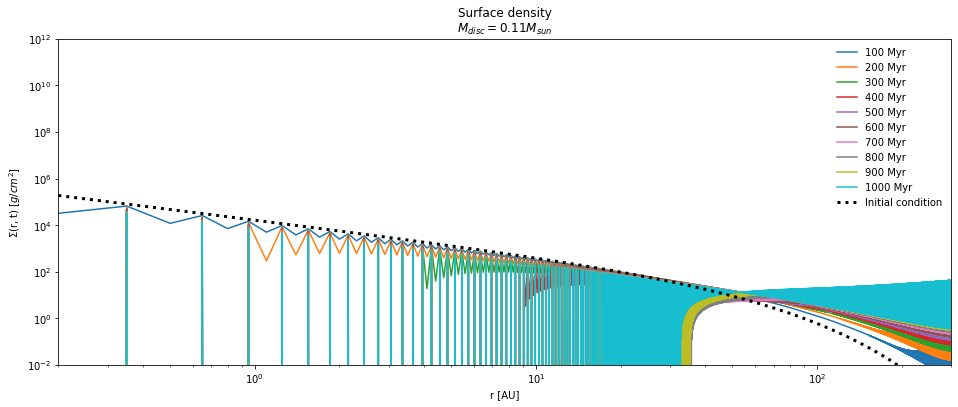

In [62]:
fig, axs = plt.subplots(figsize = (16,6))

for i in np.linspace(1e2, 1e3, 10):
    axs.loglog(r, sol.y[:, sol.t == i], label = f'{i:1.0f} Myr')


axs.plot(r, Σ_initial(r * u.au), ls=':', lw=3, c='black', label = 'Initial condition')

axs.set(xlabel = 'r [AU]', ylabel = 'Σ(r, t) [$g/cm^2$]', 
title = 'Surface density\n$M_{disc}=0.11M_{sun}$', yscale = 'log', xscale = 'log', ylim = (1e-2,1e12), xlim = (r_in, r_out))
plt.legend(frameon=False, loc='upper right' )